In [114]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

from google_drive_downloader import GoogleDriveDownloader as gdd

# Utility

In [2]:
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(0, 1))
        plt.axis("off")
    plt.show()

In [3]:
standardize = lambda x: transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))(x)

In [4]:
# Modelling Parameters

IMAGE_SHAPE = (3, 96, 96)
LATENT_DIMS = 32

In [5]:
# Set Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preprocessing

In [6]:
# Download Data

gdd.download_file_from_google_drive(file_id='178ggUZjW-pToCRRKFsIBVKnjVZSsYePp',
                                    dest_path='/content/brain-tumor-dataset.zip',
                                    unzip=True)

Unzipping...Done.


In [7]:
# Data Loader

def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((IMAGE_SHAPE[1], IMAGE_SHAPE[2])),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

In [8]:
# Datalaoder Object

data = dataset_loader("./Brain Tumor Data Set/Brain Tumor Data Set/")

In [9]:
# A Data batch

X = next(iter(data))[0]

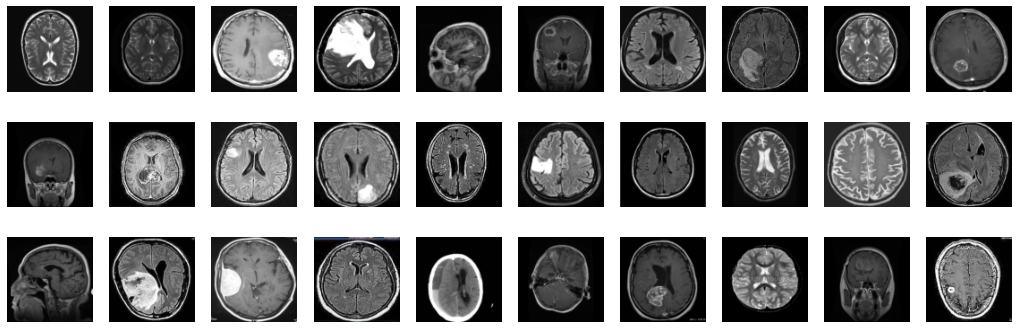

In [10]:
plot_image_samples(X)

In [11]:
# Single Image Shape

X[0].shape

torch.Size([3, 96, 96])

# Modelling

In [12]:
# Encoder Model

class Encoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, input_shape=IMAGE_SHAPE, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.input_shape = input_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2) 
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2) 
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2) 
        self.l4 = nn.Conv1d(in_channels=128, out_channels=3, kernel_size=(1,1)) 
        self.mu = nn.Linear(in_features=363, out_features=latent_dims) 
        self.log_var = nn.Linear(in_features=363, out_features=latent_dims) # Modelling with zero covariance b/n all latent dims.
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x)) # [None, 32, 47, 47]
        x = f(self.l2(x)) # [None, 64, 23, 23]
        x = f(self.l3(x)) # [None, 128, 11, 11]
        x = f(self.l4(x)) # [None, 3, 11, 11]
        x = torch.flatten(x, start_dim=1)   # [None, 3*11*11=363]
            
        # Data Distribution Parameters
        mu = self.mu(x)       # [None, latent_dims]
        log_var = self.log_var(x) # [None, latent_dims]

        return [mu, log_var]

In [13]:
# Decoder Model

class Decoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, output_shape=IMAGE_SHAPE, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.output_shape = output_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Linear(in_features=latent_dims, out_features=4*latent_dims)
        self.l2 = nn.Linear(in_features=4*latent_dims, out_features=8*latent_dims)
        self.l3 = nn.Linear(in_features=8*latent_dims, out_features=16*latent_dims)
        self.l4 = nn.ConvTranspose2d(in_channels=2, out_channels=output_shape[0], kernel_size=(3,3), stride=3)
        self.l5 = nn.ConvTranspose2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(3,3), stride=2)
        self.l6 = nn.Conv2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(2,2))
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x))     # [None, latent_dim*4]
        x = f(self.l2(x))     # [None, latent_dim*8]
        x = f(self.l3(x))     # [None, latent_dim*16]
        x = torch.reshape(x, (-1, 2, self.latent_dims//2, self.latent_dims//2)) # [None, 2, 16, 16]
        x = f(self.l4(x))     # [None, 3, 48, 48]
        x = f(self.l5(x))     # [None, 3, 97, 97]
        x = torch.sigmoid(self.l6(x))     # [None, 3, 96, 96]
        return x

KL divergence of two gaussian is defined as

$$KL(p||q) = {1 \over 2}\Bigg(\log\Bigg( \frac{|\Sigma_2|}{|\Sigma_1|}\Bigg)  -n + Trace\Big(\Sigma_2^{-1}\Sigma_1 \Big) + (\mu_2 - \mu_1)^T\Sigma_2^{-1}(\mu_2 - \mu_1)\Bigg)$$

where $P \sim N(\mu_1, \Sigma_1)$ and $Q \sim N(\mu_2, \Sigma_2)$.

In our case $Q = N(\vec0, \mathbb{I})$. It reduces KL to

$$KL(p||q) = {1 \over 2}\Bigg(-\log\big( |\Sigma_1|\big)  -n + Trace\Big(\Sigma_1 \Big) + \mu_1^2\Bigg)$$

In [14]:
# Variational AutoEncoder

class VAE(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, image_shape=IMAGE_SHAPE, beta=10.0, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.encoder = Encoder(latent_dims, image_shape)
        self.decoder = Decoder(latent_dims, image_shape)
        self.beta = beta

        self.kl_loss = None
        self.reconstr_loss = None

    def forward(self, x):
        # Get Data Distribution's Parameters
        mu, log_var = self.encoder(x)
        
        # Reparameterization Trick
        z = mu + torch.exp(0.5*log_var)*torch.randn_like(mu) if self.training else mu

        # Reocnstruct Data points using latent space embeddings.
        reconstructed_x = self.decoder(z)
        
        if self.training:
            # We can use any metric function here.
            #self.reconstr_loss = MSE(reconstructed_x, x, reduction="mean")
            #self.reconstr_loss = NegLogLik(reconstructed_x, x, reduction="mean")
            self.reconstr_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
            
            self.kl_loss = self.beta * 0.5 * torch.sum(-log_var - 1 + torch.exp(log_var) + torch.square(mu))
    
        return reconstructed_x, mu, log_var


In [15]:
# Model Instantiation
model = VAE(beta=10)
model = model.to(device)

# Forward Propagation
X_bar, _, _ = model.forward(X.to(device))

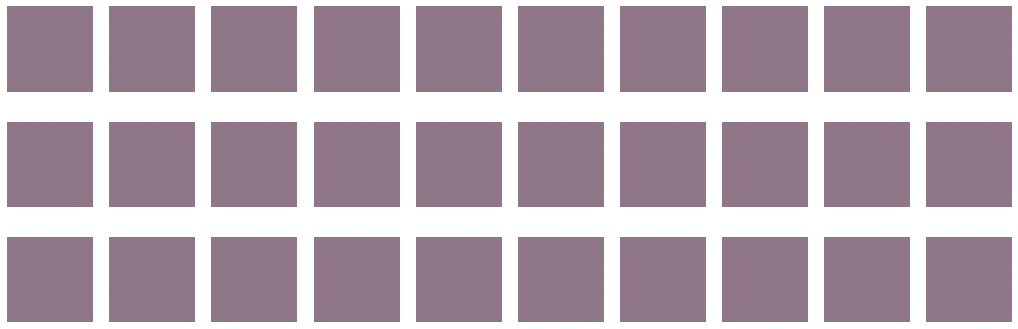

In [16]:
# Output of untrained VAE

plot_image_samples(X_bar[:].detach().cpu())

# Training Loop

In [17]:
# Training Params

opt = torch.optim.Adam(model.parameters())
EPOCHS = 100
THRESHOLD = 1e-4
PATIENCE = 8

history = {'recon-loss': [0], 'kl-loss': [0]}

Epoch [1 / 100] 
    - KL-Loss:  1415.119910 
    - Recon-Loss:  552253.883030 
    - Total-Loss:  553669.002940
    - Time-Taken:  16.963451 sec

Epoch [2 / 100] 
    - KL-Loss:  2862.867805 
    - Recon-Loss:  423018.465929 
    - Total-Loss:  425881.333734
    - Time-Taken:  16.518942 sec

Epoch [3 / 100] 
    - KL-Loss:  3091.688818 
    - Recon-Loss:  414197.914280 
    - Total-Loss:  417289.603098
    - Time-Taken:  16.352139 sec

Epoch [4 / 100] 
    - KL-Loss:  2995.590483 
    - Recon-Loss:  411244.033420 
    - Total-Loss:  414239.623903
    - Time-Taken:  16.241953 sec

Epoch [5 / 100] 
    - KL-Loss:  2839.013061 
    - Recon-Loss:  410283.823568 
    - Total-Loss:  413122.836628
    - Time-Taken:  16.412420 sec



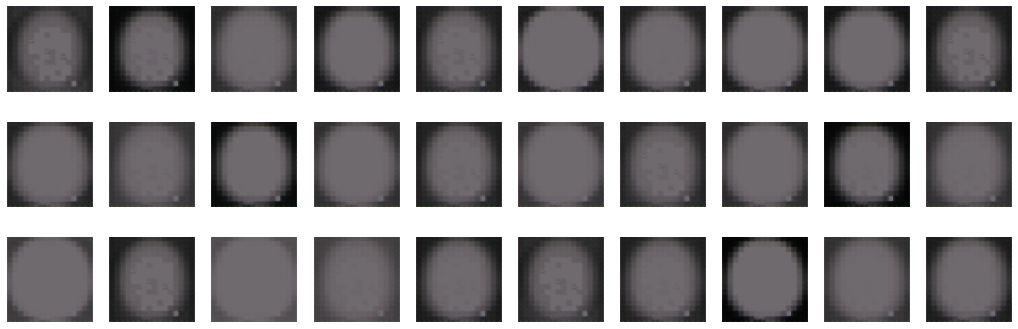

Epoch [6 / 100] 
    - KL-Loss:  2710.764364 
    - Recon-Loss:  409287.501085 
    - Total-Loss:  411998.265450
    - Time-Taken:  16.257508 sec

Epoch [7 / 100] 
    - KL-Loss:  2746.207436 
    - Recon-Loss:  407631.148003 
    - Total-Loss:  410377.355440
    - Time-Taken:  16.417443 sec

Epoch [8 / 100] 
    - KL-Loss:  2737.604092 
    - Recon-Loss:  406260.873481 
    - Total-Loss:  408998.477573
    - Time-Taken:  16.393135 sec

Epoch [9 / 100] 
    - KL-Loss:  2651.627375 
    - Recon-Loss:  405595.167318 
    - Total-Loss:  408246.794693
    - Time-Taken:  16.427019 sec

Epoch [10 / 100] 
    - KL-Loss:  2570.870394 
    - Recon-Loss:  404903.835286 
    - Total-Loss:  407474.705680
    - Time-Taken:  16.198229 sec



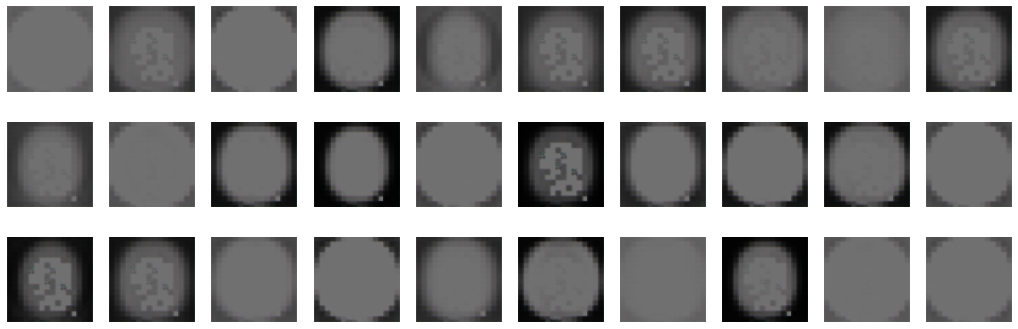

Epoch [11 / 100] 
    - KL-Loss:  2531.605167 
    - Recon-Loss:  404299.221137 
    - Total-Loss:  406830.826304
    - Time-Taken:  16.338547 sec

Epoch [12 / 100] 
    - KL-Loss:  2520.276584 
    - Recon-Loss:  403483.557726 
    - Total-Loss:  406003.834310
    - Time-Taken:  16.279745 sec

Epoch [13 / 100] 
    - KL-Loss:  2596.570002 
    - Recon-Loss:  402752.758681 
    - Total-Loss:  405349.328683
    - Time-Taken:  16.334137 sec

Epoch [14 / 100] 
    - KL-Loss:  2709.867872 
    - Recon-Loss:  401836.575087 
    - Total-Loss:  404546.442959
    - Time-Taken:  16.181726 sec

Epoch [15 / 100] 
    - KL-Loss:  2934.472026 
    - Recon-Loss:  400930.449436 
    - Total-Loss:  403864.921461
    - Time-Taken:  16.303457 sec



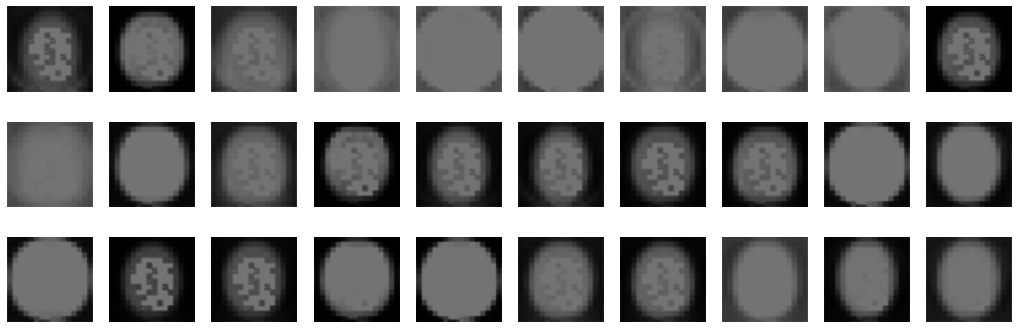

Epoch [16 / 100] 
    - KL-Loss:  2923.773244 
    - Recon-Loss:  400386.745877 
    - Total-Loss:  403310.519121
    - Time-Taken:  16.304809 sec

Epoch [17 / 100] 
    - KL-Loss:  2975.315840 
    - Recon-Loss:  400113.003472 
    - Total-Loss:  403088.319312
    - Time-Taken:  16.313269 sec

Epoch [18 / 100] 
    - KL-Loss:  2998.624159 
    - Recon-Loss:  399667.552734 
    - Total-Loss:  402666.176893
    - Time-Taken:  16.350128 sec

Epoch [19 / 100] 
    - KL-Loss:  3099.020364 
    - Recon-Loss:  399058.230252 
    - Total-Loss:  402157.250615
    - Time-Taken:  16.288229 sec

Epoch [20 / 100] 
    - KL-Loss:  3246.529443 
    - Recon-Loss:  398105.133030 
    - Total-Loss:  401351.662472
    - Time-Taken:  16.249502 sec



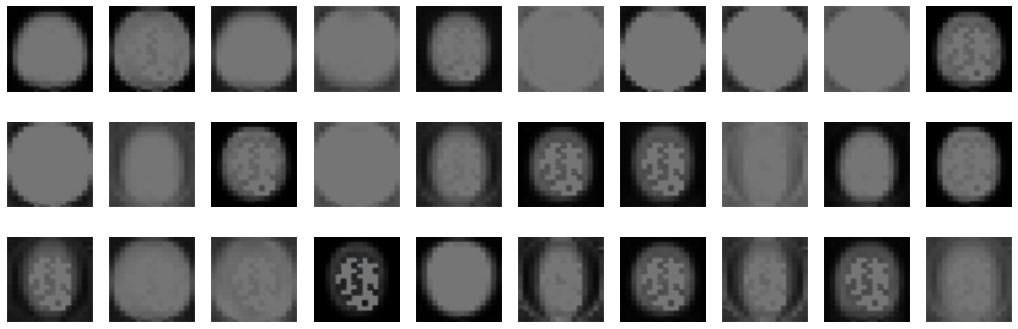

Epoch [21 / 100] 
    - KL-Loss:  3313.021503 
    - Recon-Loss:  397401.362630 
    - Total-Loss:  400714.384133
    - Time-Taken:  16.286030 sec

Epoch [22 / 100] 
    - KL-Loss:  3357.722390 
    - Recon-Loss:  397120.807726 
    - Total-Loss:  400478.530116
    - Time-Taken:  16.168285 sec

Epoch [23 / 100] 
    - KL-Loss:  3319.907678 
    - Recon-Loss:  396682.829861 
    - Total-Loss:  400002.737539
    - Time-Taken:  16.296230 sec

Epoch [24 / 100] 
    - KL-Loss:  3350.562914 
    - Recon-Loss:  396447.762804 
    - Total-Loss:  399798.325718
    - Time-Taken:  16.135562 sec

Epoch [25 / 100] 
    - KL-Loss:  3371.135547 
    - Recon-Loss:  396130.037326 
    - Total-Loss:  399501.172874
    - Time-Taken:  16.227656 sec



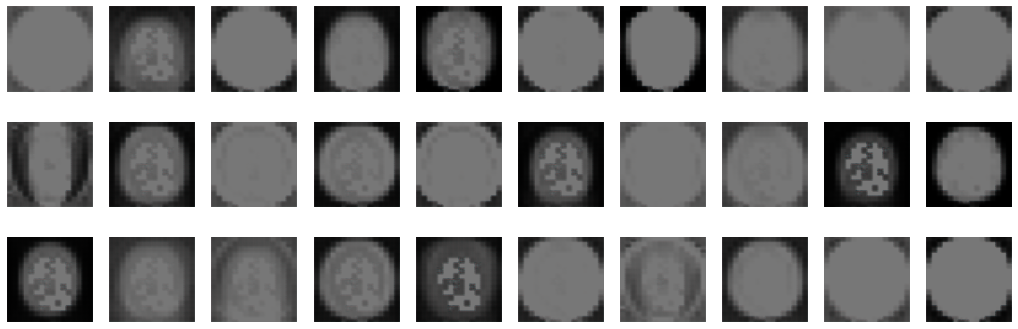

Epoch [26 / 100] 
    - KL-Loss:  3414.656976 
    - Recon-Loss:  395702.143663 
    - Total-Loss:  399116.800639
    - Time-Taken:  16.138052 sec

Epoch [27 / 100] 
    - KL-Loss:  3423.813649 
    - Recon-Loss:  395315.367622 
    - Total-Loss:  398739.181271
    - Time-Taken:  16.298488 sec

Epoch [28 / 100] 
    - KL-Loss:  3403.098729 
    - Recon-Loss:  394918.301649 
    - Total-Loss:  398321.400379
    - Time-Taken:  16.231600 sec

Epoch [29 / 100] 
    - KL-Loss:  3420.987440 
    - Recon-Loss:  394691.397135 
    - Total-Loss:  398112.384576
    - Time-Taken:  16.243492 sec

Epoch [30 / 100] 
    - KL-Loss:  3475.105353 
    - Recon-Loss:  394253.705295 
    - Total-Loss:  397728.810649
    - Time-Taken:  16.176018 sec



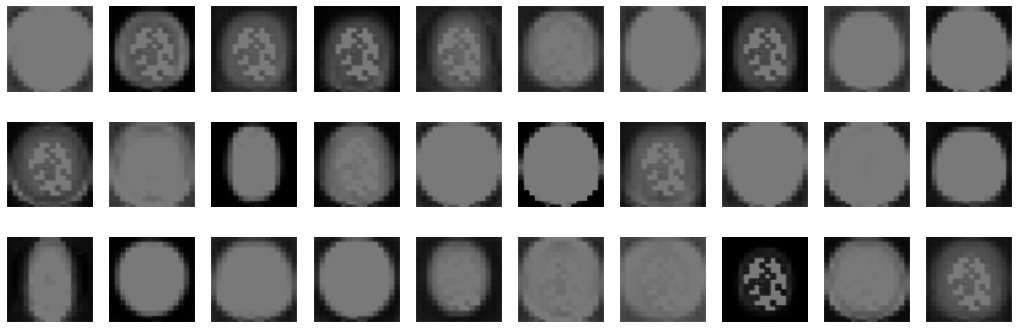

Epoch [31 / 100] 
    - KL-Loss:  3505.514359 
    - Recon-Loss:  394018.601997 
    - Total-Loss:  397524.116355
    - Time-Taken:  16.223346 sec

Epoch [32 / 100] 
    - KL-Loss:  3534.959627 
    - Recon-Loss:  393712.489149 
    - Total-Loss:  397247.448776
    - Time-Taken:  16.200489 sec

Epoch [33 / 100] 
    - KL-Loss:  3560.707292 
    - Recon-Loss:  393560.361979 
    - Total-Loss:  397121.069272
    - Time-Taken:  16.302330 sec

Epoch [34 / 100] 
    - KL-Loss:  3593.237888 
    - Recon-Loss:  393359.041233 
    - Total-Loss:  396952.279121
    - Time-Taken:  16.143076 sec

Epoch [35 / 100] 
    - KL-Loss:  3607.090113 
    - Recon-Loss:  393134.988932 
    - Total-Loss:  396742.079046
    - Time-Taken:  16.203934 sec



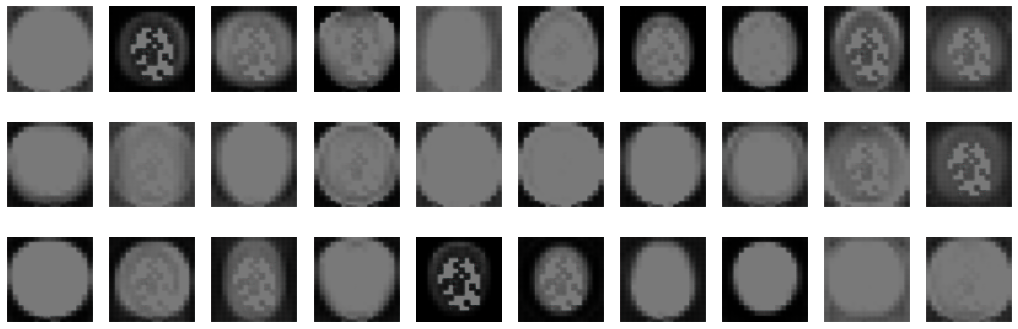

Epoch [36 / 100] 
    - KL-Loss:  3639.301792 
    - Recon-Loss:  392957.998481 
    - Total-Loss:  396597.300273
    - Time-Taken:  16.167865 sec

Epoch [37 / 100] 
    - KL-Loss:  3667.989249 
    - Recon-Loss:  392898.602648 
    - Total-Loss:  396566.591897
    - Time-Taken:  16.277060 sec

Epoch [38 / 100] 
    - KL-Loss:  3690.840454 
    - Recon-Loss:  392790.549479 
    - Total-Loss:  396481.389933
    - Time-Taken:  16.289594 sec

Epoch [39 / 100] 
    - KL-Loss:  3701.569636 
    - Recon-Loss:  392612.313802 
    - Total-Loss:  396313.883438
    - Time-Taken:  16.291609 sec

Epoch [40 / 100] 
    - KL-Loss:  3699.239563 
    - Recon-Loss:  392391.041233 
    - Total-Loss:  396090.280796
    - Time-Taken:  16.221387 sec



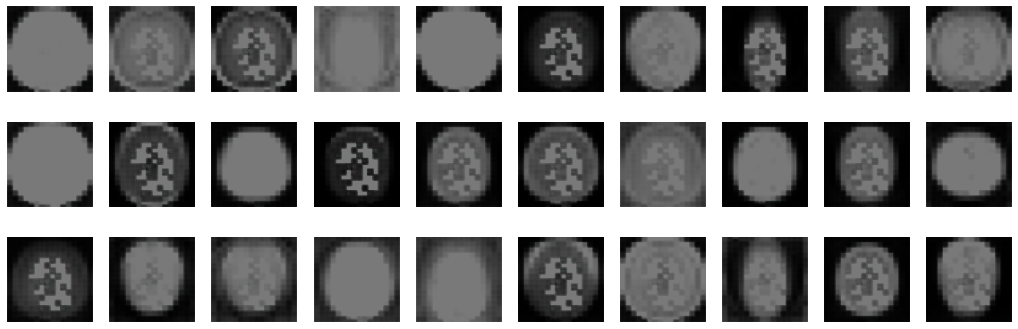

Epoch [41 / 100] 
    - KL-Loss:  3726.855586 
    - Recon-Loss:  392194.004123 
    - Total-Loss:  395920.859709
    - Time-Taken:  16.347473 sec

Epoch [42 / 100] 
    - KL-Loss:  3739.281221 
    - Recon-Loss:  391882.700521 
    - Total-Loss:  395621.981742
    - Time-Taken:  16.243773 sec

Epoch [43 / 100] 
    - KL-Loss:  3773.937586 
    - Recon-Loss:  391679.492188 
    - Total-Loss:  395453.429774
    - Time-Taken:  16.202445 sec

Epoch [44 / 100] 
    - KL-Loss:  3778.038433 
    - Recon-Loss:  391392.126085 
    - Total-Loss:  395170.164519
    - Time-Taken:  16.078311 sec

Epoch [45 / 100] 
    - KL-Loss:  3797.665068 
    - Recon-Loss:  391303.930990 
    - Total-Loss:  395101.596057
    - Time-Taken:  16.280889 sec



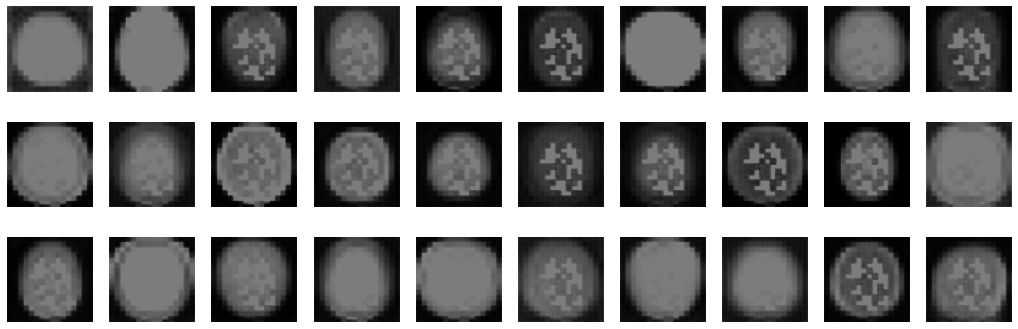

Epoch [46 / 100] 
    - KL-Loss:  3798.600008 
    - Recon-Loss:  390984.568793 
    - Total-Loss:  394783.168801
    - Time-Taken:  16.200911 sec

Epoch [47 / 100] 
    - KL-Loss:  3815.121009 
    - Recon-Loss:  390871.133681 
    - Total-Loss:  394686.254690
    - Time-Taken:  16.264234 sec

Epoch [48 / 100] 
    - KL-Loss:  3814.511642 
    - Recon-Loss:  390792.005208 
    - Total-Loss:  394606.516851
    - Time-Taken:  16.168609 sec

Epoch [49 / 100] 
    - KL-Loss:  3816.114415 
    - Recon-Loss:  390687.844835 
    - Total-Loss:  394503.959251
    - Time-Taken:  16.249674 sec

Epoch [50 / 100] 
    - KL-Loss:  3867.107619 
    - Recon-Loss:  390462.074870 
    - Total-Loss:  394329.182488
    - Time-Taken:  16.087626 sec



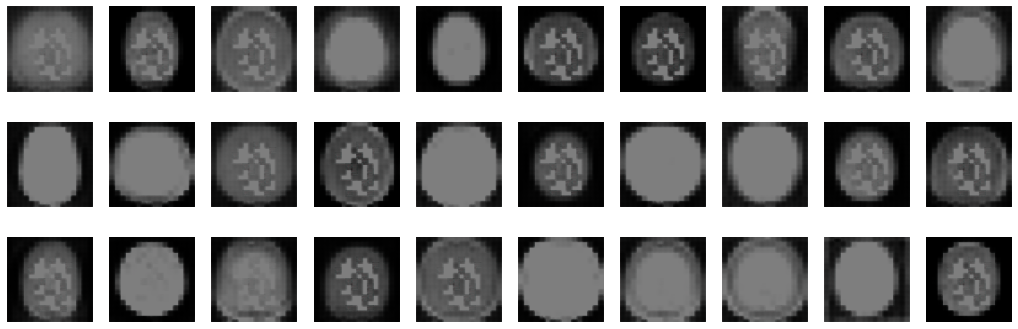

Epoch [51 / 100] 
    - KL-Loss:  3865.681485 
    - Recon-Loss:  390330.100260 
    - Total-Loss:  394195.781745
    - Time-Taken:  16.264940 sec

Epoch [52 / 100] 
    - KL-Loss:  3860.052550 
    - Recon-Loss:  390239.461372 
    - Total-Loss:  394099.513921
    - Time-Taken:  16.276814 sec

Epoch [53 / 100] 
    - KL-Loss:  3881.850923 
    - Recon-Loss:  390095.042101 
    - Total-Loss:  393976.893024
    - Time-Taken:  16.266433 sec

Epoch [54 / 100] 
    - KL-Loss:  3893.293232 
    - Recon-Loss:  390015.232856 
    - Total-Loss:  393908.526087
    - Time-Taken:  16.155031 sec

Epoch [55 / 100] 
    - KL-Loss:  3885.171985 
    - Recon-Loss:  389964.360243 
    - Total-Loss:  393849.532228
    - Time-Taken:  16.170908 sec



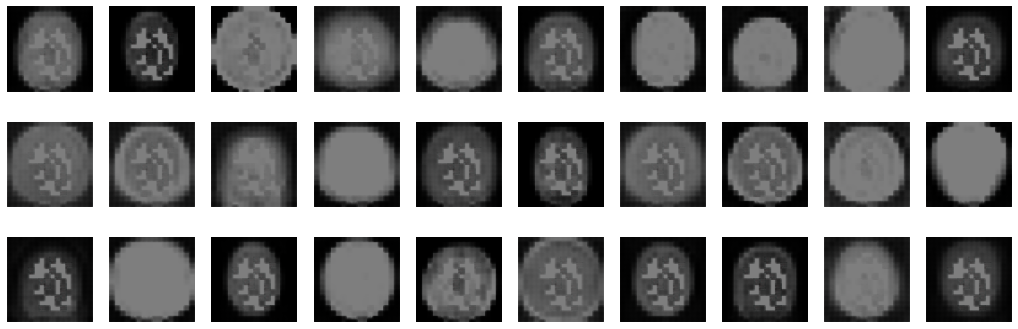

Epoch [56 / 100] 
    - KL-Loss:  3923.644213 
    - Recon-Loss:  389698.017361 
    - Total-Loss:  393621.661574
    - Time-Taken:  16.187041 sec

Epoch [57 / 100] 
    - KL-Loss:  3920.473238 
    - Recon-Loss:  389583.172309 
    - Total-Loss:  393503.645547
    - Time-Taken:  16.243575 sec

Epoch [58 / 100] 
    - KL-Loss:  3922.843594 
    - Recon-Loss:  389542.951389 
    - Total-Loss:  393465.794983
    - Time-Taken:  16.188110 sec

Epoch [59 / 100] 
    - KL-Loss:  3953.832403 
    - Recon-Loss:  389498.392144 
    - Total-Loss:  393452.224547
    - Time-Taken:  16.298705 sec

Epoch [60 / 100] 
    - KL-Loss:  3931.076285 
    - Recon-Loss:  389354.490668 
    - Total-Loss:  393285.566954
    - Time-Taken:  16.221201 sec



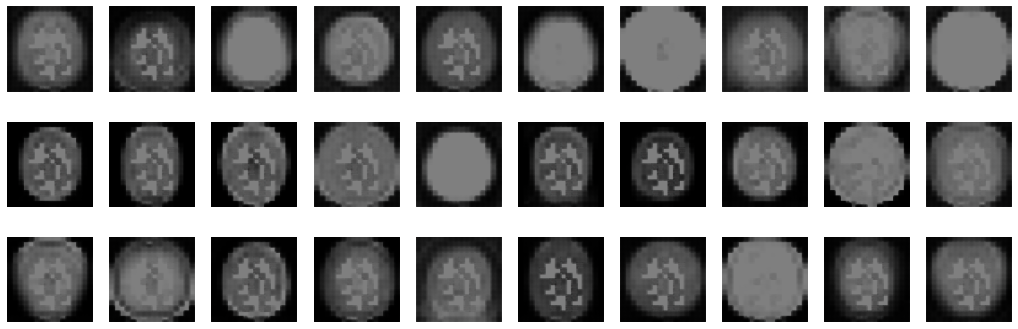

Epoch [61 / 100] 
    - KL-Loss:  3948.218270 
    - Recon-Loss:  389287.638238 
    - Total-Loss:  393235.856508
    - Time-Taken:  16.245236 sec

Epoch [62 / 100] 
    - KL-Loss:  3973.686245 
    - Recon-Loss:  389246.475694 
    - Total-Loss:  393220.161940
    - Time-Taken:  16.201665 sec

Epoch [63 / 100] 
    - KL-Loss:  3996.136317 
    - Recon-Loss:  389226.424045 
    - Total-Loss:  393222.560362
    - Time-Taken:  16.347448 sec

Epoch [64 / 100] 
    - KL-Loss:  3990.966641 
    - Recon-Loss:  389153.171658 
    - Total-Loss:  393144.138299
    - Time-Taken:  16.113680 sec

Epoch [65 / 100] 
    - KL-Loss:  3996.490702 
    - Recon-Loss:  389087.903863 
    - Total-Loss:  393084.394565
    - Time-Taken:  16.233168 sec



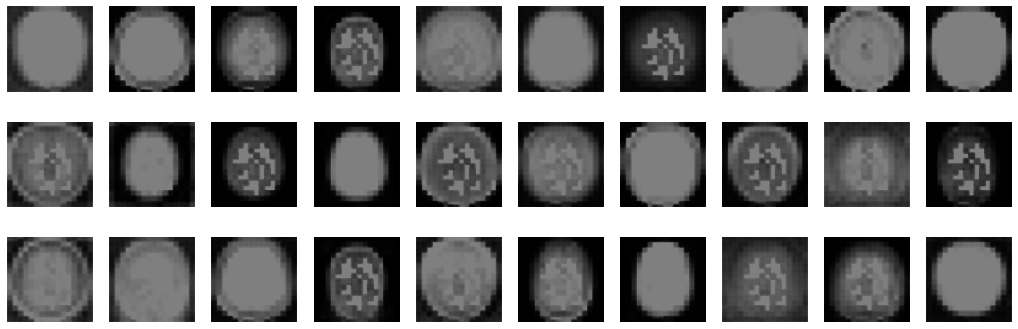

Epoch [66 / 100] 
    - KL-Loss:  4021.395860 
    - Recon-Loss:  388980.891493 
    - Total-Loss:  393002.287354
    - Time-Taken:  16.189499 sec

Epoch [67 / 100] 
    - KL-Loss:  4029.943746 
    - Recon-Loss:  388925.660156 
    - Total-Loss:  392955.603902
    - Time-Taken:  16.339746 sec

Epoch [68 / 100] 
    - KL-Loss:  4042.615397 
    - Recon-Loss:  388835.614800 
    - Total-Loss:  392878.230197
    - Time-Taken:  16.108259 sec

Epoch [69 / 100] 
    - KL-Loss:  4040.868500 
    - Recon-Loss:  388800.664714 
    - Total-Loss:  392841.533213
    - Time-Taken:  16.221403 sec

Epoch [70 / 100] 
    - KL-Loss:  4076.737525 
    - Recon-Loss:  388714.652778 
    - Total-Loss:  392791.390303
    - Time-Taken:  16.155943 sec



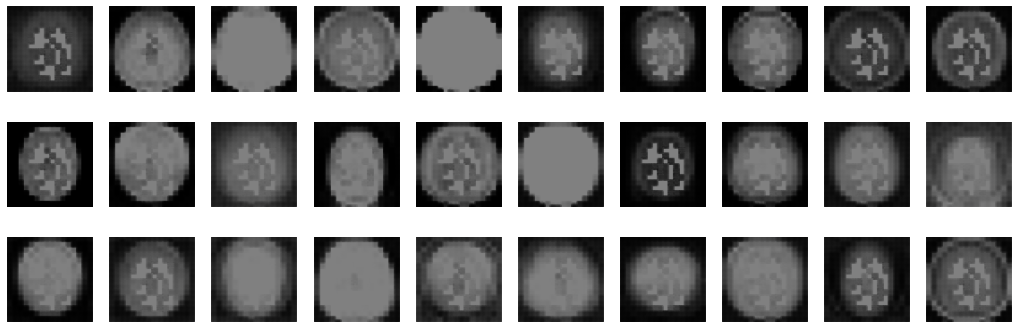

Epoch [71 / 100] 
    - KL-Loss:  4076.818914 
    - Recon-Loss:  388688.419054 
    - Total-Loss:  392765.237968
    - Time-Taken:  16.290268 sec

Epoch [72 / 100] 
    - KL-Loss:  4083.338370 
    - Recon-Loss:  388586.693359 
    - Total-Loss:  392670.031730
    - Time-Taken:  16.262733 sec

Epoch [73 / 100] 
    - KL-Loss:  4094.030334 
    - Recon-Loss:  388532.285590 
    - Total-Loss:  392626.315925
    - Time-Taken:  16.220654 sec

Epoch [74 / 100] 
    - KL-Loss:  4092.180140 
    - Recon-Loss:  388489.689887 
    - Total-Loss:  392581.870027
    - Time-Taken:  16.170299 sec

Epoch [75 / 100] 
    - KL-Loss:  4104.318815 
    - Recon-Loss:  388417.245009 
    - Total-Loss:  392521.563824
    - Time-Taken:  16.159073 sec



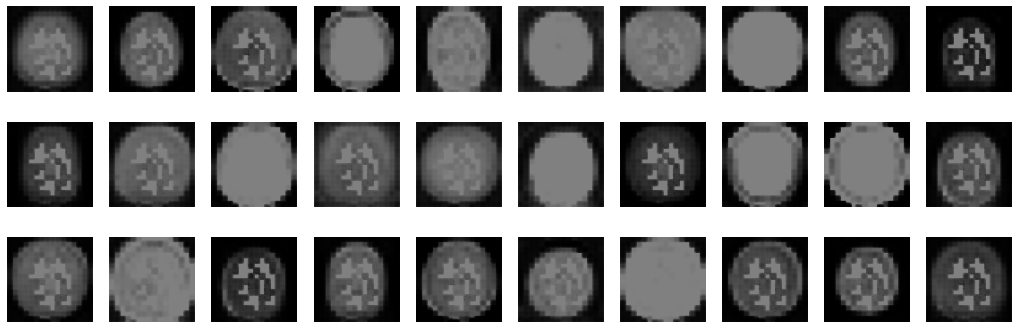

Epoch [76 / 100] 
    - KL-Loss:  4113.986394 
    - Recon-Loss:  388392.576606 
    - Total-Loss:  392506.563000
    - Time-Taken:  16.153027 sec

Epoch [77 / 100] 
    - KL-Loss:  4128.233273 
    - Recon-Loss:  388351.869358 
    - Total-Loss:  392480.102631
    - Time-Taken:  16.392588 sec

Epoch [78 / 100] 
    - KL-Loss:  4125.214820 
    - Recon-Loss:  388277.789714 
    - Total-Loss:  392403.004534
    - Time-Taken:  16.183671 sec

Epoch [79 / 100] 
    - KL-Loss:  4152.128479 
    - Recon-Loss:  388188.881944 
    - Total-Loss:  392341.010423
    - Time-Taken:  16.168443 sec

Epoch [80 / 100] 
    - KL-Loss:  4155.833649 
    - Recon-Loss:  388177.370877 
    - Total-Loss:  392333.204525
    - Time-Taken:  16.055625 sec



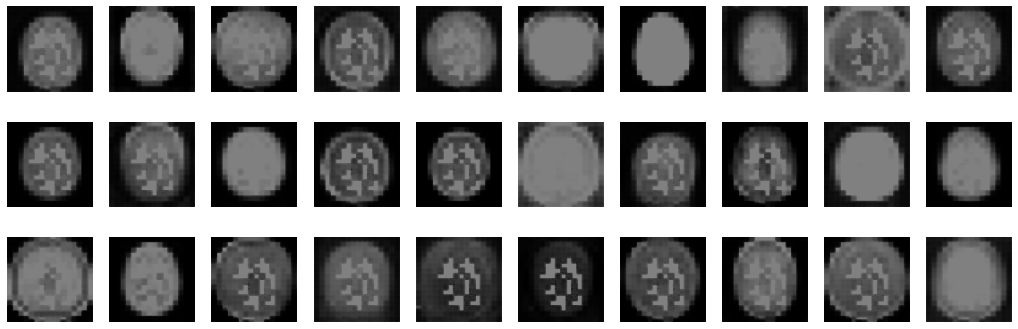

Epoch [81 / 100] 
    - KL-Loss:  4145.118144 
    - Recon-Loss:  388101.388021 
    - Total-Loss:  392246.506165
    - Time-Taken:  16.348320 sec

Epoch [82 / 100] 
    - KL-Loss:  4151.230682 
    - Recon-Loss:  388048.106120 
    - Total-Loss:  392199.336802
    - Time-Taken:  16.252919 sec

Epoch [83 / 100] 
    - KL-Loss:  4206.533557 
    - Recon-Loss:  388046.308160 
    - Total-Loss:  392252.841717
    - Time-Taken:  16.155418 sec

Epoch [84 / 100] 
    - KL-Loss:  4192.310001 
    - Recon-Loss:  387977.386719 
    - Total-Loss:  392169.696720
    - Time-Taken:  16.033020 sec

Epoch [85 / 100] 
    - KL-Loss:  4222.952844 
    - Recon-Loss:  387934.579427 
    - Total-Loss:  392157.532271
    - Time-Taken:  16.275219 sec



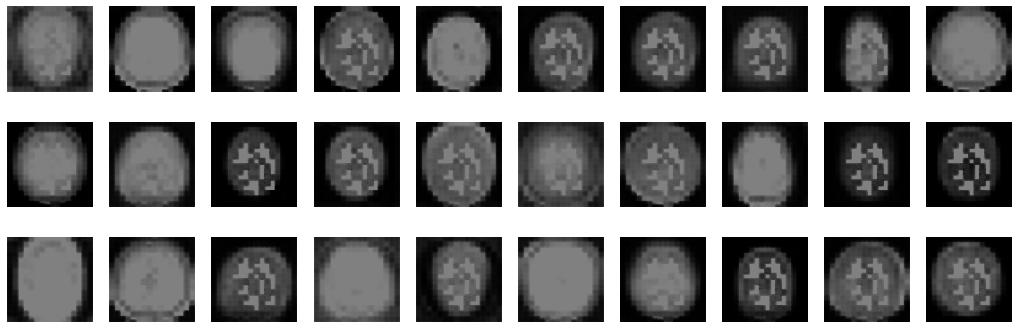

Epoch [86 / 100] 
    - KL-Loss:  4213.769702 
    - Recon-Loss:  387870.876085 
    - Total-Loss:  392084.645788
    - Time-Taken:  16.189407 sec

Epoch [87 / 100] 
    - KL-Loss:  4214.026196 
    - Recon-Loss:  387866.837240 
    - Total-Loss:  392080.863436
    - Time-Taken:  16.286029 sec

Epoch [88 / 100] 
    - KL-Loss:  4212.035104 
    - Recon-Loss:  387809.498047 
    - Total-Loss:  392021.533151
    - Time-Taken:  16.194921 sec

Epoch [89 / 100] 
    - KL-Loss:  4209.064646 
    - Recon-Loss:  387725.297526 
    - Total-Loss:  391934.362172
    - Time-Taken:  16.231620 sec

Epoch [90 / 100] 
    - KL-Loss:  4235.737449 
    - Recon-Loss:  387689.067491 
    - Total-Loss:  391924.804940
    - Time-Taken:  16.081649 sec



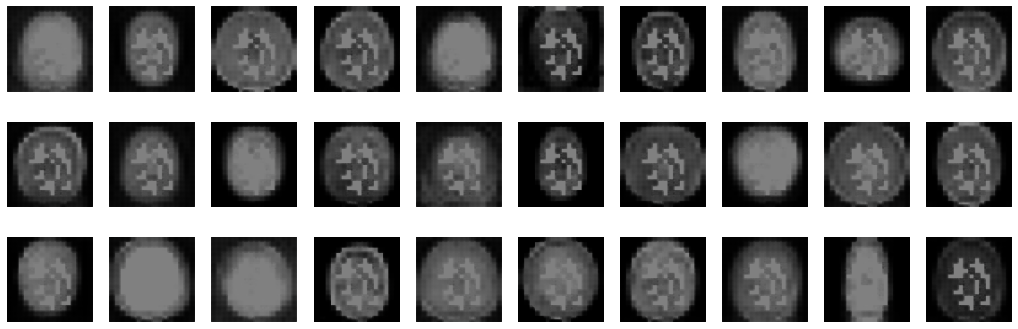

Epoch [91 / 100] 
    - KL-Loss:  4254.159965 
    - Recon-Loss:  387651.290582 
    - Total-Loss:  391905.450546
    - Time-Taken:  16.283236 sec

Epoch [92 / 100] 
    - KL-Loss:  4238.937176 
    - Recon-Loss:  387697.069878 
    - Total-Loss:  391936.007055
    - Time-Taken:  16.226642 sec

Epoch [93 / 100] 
    - KL-Loss:  4252.420556 
    - Recon-Loss:  387533.121311 
    - Total-Loss:  391785.541867
    - Time-Taken:  16.273117 sec

Epoch [94 / 100] 
    - KL-Loss:  4259.798547 
    - Recon-Loss:  387502.095920 
    - Total-Loss:  391761.894467
    - Time-Taken:  16.297139 sec

Epoch [95 / 100] 
    - KL-Loss:  4245.953172 
    - Recon-Loss:  387497.483290 
    - Total-Loss:  391743.436462
    - Time-Taken:  16.290292 sec



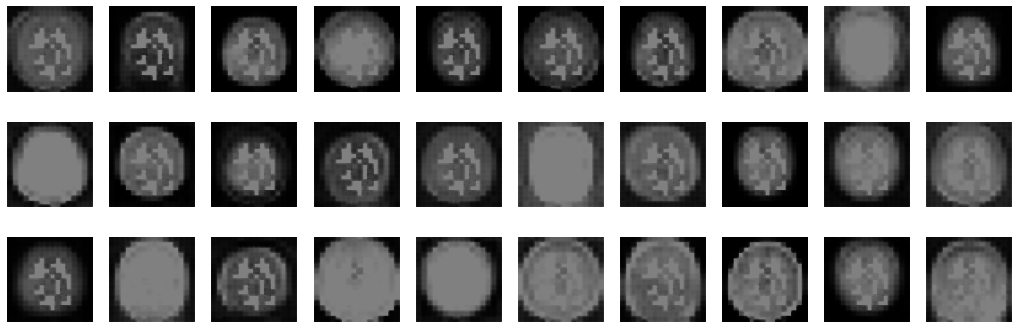

Epoch [96 / 100] 
    - KL-Loss:  4285.196097 
    - Recon-Loss:  387494.308811 
    - Total-Loss:  391779.504908
    - Time-Taken:  16.518227 sec

Epoch [97 / 100] 
    - KL-Loss:  4273.426276 
    - Recon-Loss:  387397.984592 
    - Total-Loss:  391671.410868
    - Time-Taken:  16.708130 sec

Epoch [98 / 100] 
    - KL-Loss:  4296.679933 
    - Recon-Loss:  387373.577908 
    - Total-Loss:  391670.257841
    - Time-Taken:  17.111464 sec

Epoch [99 / 100] 
    - KL-Loss:  4290.174874 
    - Recon-Loss:  387374.137804 
    - Total-Loss:  391664.312678
    - Time-Taken:  17.069942 sec

Epoch [100 / 100] 
    - KL-Loss:  4306.249603 
    - Recon-Loss:  387309.863932 
    - Total-Loss:  391616.113536
    - Time-Taken:  16.749597 sec



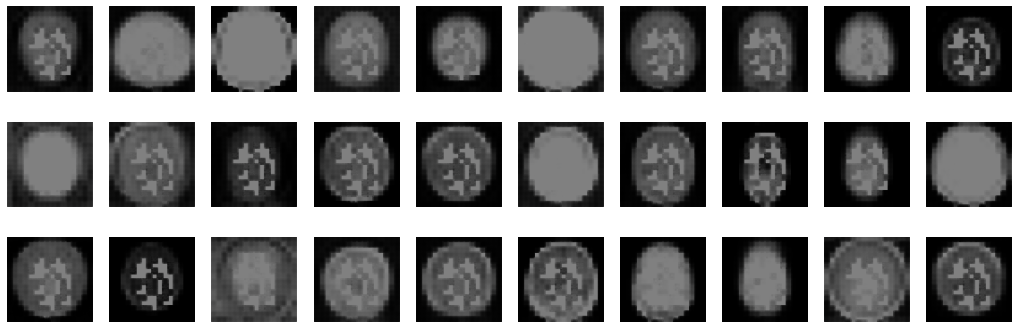

Epoch [101 / 100] 
    - KL-Loss:  4301.271447 
    - Recon-Loss:  387283.072917 
    - Total-Loss:  391584.344364
    - Time-Taken:  16.353138 sec



In [19]:
# Custom Training Loop

model.train()

round = 0
loss_inc_count = 0

for epoch in range(EPOCHS):
    count = 0
    tick = time()
    l1, l2 = 0, 0

    for idx, X in enumerate(data):
        count += 1

        # Copy data to Device
        X = X[0].to(device)

        # Forward Pass
        reconstructed_x, mu, log_var = model.forward(X)
        
        # Loss Calculation
        rec_loss = model.reconstr_loss
        kl_loss = model.kl_loss
        loss = rec_loss + kl_loss
        
        # Backpropagation
        opt.zero_grad()
        loss.backward()
        
        # Apply Jacobians to Weights
        opt.step()

        l1 += rec_loss.item()
        l2 += kl_loss.item()
        
    # Log Training
    history["recon-loss"].append(l1/count)
    history["kl-loss"].append(l2/count)
    
    # Training Moniotring
    tock = time()
    round += 1
    print(f"""Epoch [{round} / {EPOCHS}] 
    - KL-Loss: {history["kl-loss"][-1]: 0.6f} 
    - Recon-Loss: {history["recon-loss"][-1]: 0.6f} 
    - Total-Loss: {(history["kl-loss"][-1] + history["recon-loss"][-1]): 0.6f}
    - Time-Taken: {(tock-tick): 0.6f} sec""", end="\n\n")
    
    # Plot Randomly Sampled Latent Embeddings
    if round%5 == 0:
        plot_image_samples(model.decoder(torch.randn((32, LATENT_DIMS)).to(device)).detach().cpu())
        print()

    # Early Stopping
    if (history["kl-loss"][-1]  - history["kl-loss"][-2] + history["recon-loss"][-1] - history["recon-loss"][-2]) < 0:
        loss_inc_count += 0
    if ((abs(history["kl-loss"][-1]  - history["kl-loss"][-2]) + abs(history["recon-loss"][-1] - history["recon-loss"][-2])) <= THRESHOLD) or (loss_inc_count >= PATIENCE):
        break

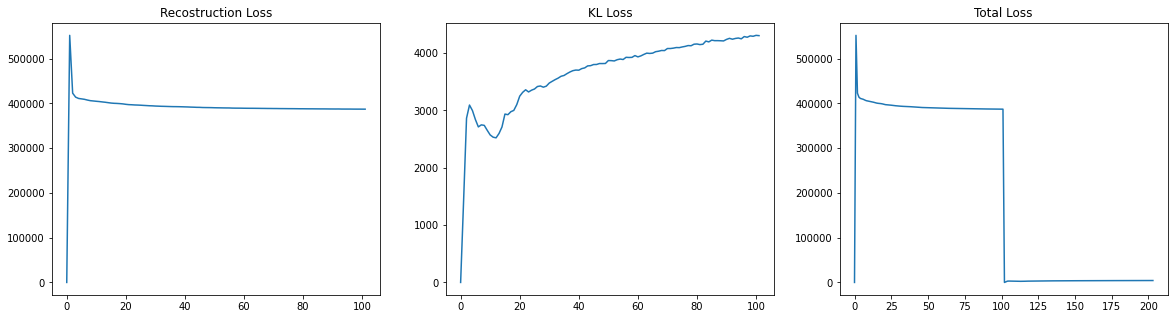

In [24]:
# Training Visualization

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history["recon-loss"])
plt.title("Recostruction Loss")

plt.subplot(1, 3, 2)
plt.plot(history["kl-loss"])
plt.title("KL Loss")

plt.subplot(1, 3, 3)
plt.plot(history["recon-loss"]+history["kl-loss"])
plt.title("Total Loss")

plt.show()

In [115]:
data.dataset.class_to_idx

{'Brain Tumor': 0, 'Healthy': 1}

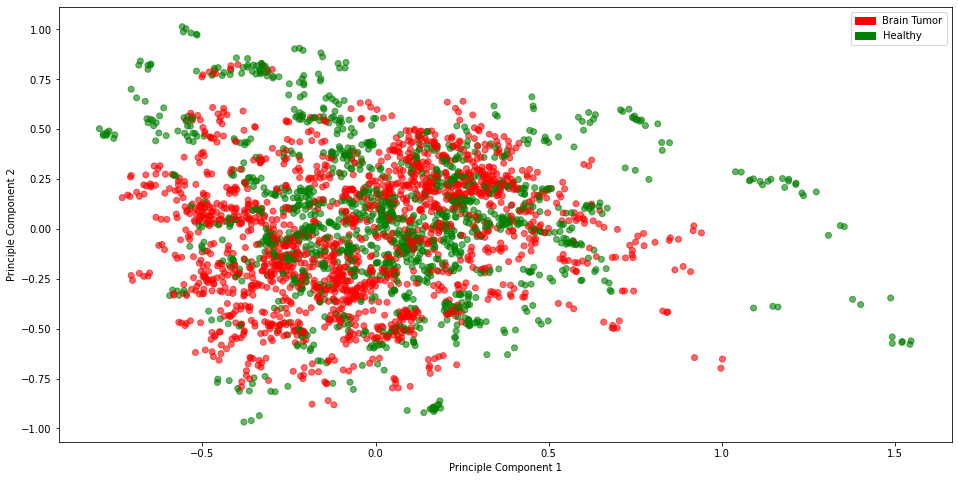

In [117]:
# Visualizing Latent Space

N = 1000 #No of Parameters
N_sample = 3 #No. of Samples per parameter

# Sampling Images
temp = [next(iter(data)) for _ in range(N//32 + 1)]
X = torch.vstack([x[0] for x in temp])
Y = torch.hstack([x[1] for x in temp])

# Forward Pass through Encoder
mu_, _log_var = model.encoder(X.to(device))

# Sampling from Normal Disitrbution using predicted Parameters
embeddings = torch.vstack([torch.normal(mu_, 0.5*torch.exp(_log_var)) for _ in range(N_sample)]).detach().cpu().numpy()
embedding_class = torch.hstack([Y for _ in range(N_sample)]).detach().cpu().numpy()

# Dimensionality Reduction
low_dim_embeddings = KernelPCA(n_components=2, kernel="poly").fit_transform(embeddings)

# Plotting Principle Components
colors = {0: "red", 1:"green"}
red_patch = mpatches.Patch(color='red', label='Brain Tumor')
green_patch = mpatches.Patch(color='green', label='Healthy')
plt.figure(figsize=(16,8))
plt.scatter(x = low_dim_embeddings[:,0], 
            y = low_dim_embeddings[:, 1], 
            color = np.vectorize(colors.get)(embedding_class), 
            alpha=0.6)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.legend(handles=[red_patch, green_patch])
plt.show()

# Checkpointing

In [97]:
# Saving Model

torch.save(model.state_dict(), "./brain-tumor-data.pt")